## Using GP 

to do dimensionality reduction on $(r, n_1, n_2)$. We should need only 2 parameters for each axis, $l, \sigma_0$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gal_goku import summary_stats
from gal_goku import utils
import gpflow
from gpflow.utilities import print_summary
import tensorflow as tf

def normalize(X,Y):
    """
    """
    X_min, X_max = tf.reduce_min(X, axis=0), tf.reduce_max(X, axis=0)

    X = (X - X_min) / (X_max - X_min)
    medind = np.argsort(np.mean(Y, axis=1))[np.shape(Y)[0]//2]
    mean_func = Y[medind,:]
    #print(f'mean_func: {mean_func}')

    return mean_func, X_min, X_max


def dim_reduc_gp(fid = 'HF', r_range=(0.1, np.inf), kernels={'kernels':[gpflow.kernels.RBF], 'loc':[], 'train_loc':True}, lik_var=None, log_y=False):
    """
    Development code for finding best GP model for dimensionality reduction
    Parameters
    ----------
    r_range : tuple
        Range of r to consider for fitting the GP model. supported ranege is (0.1, 80) for now
    kernels : dict
        Dictionary of kernel functions to use. The key 'kernels' should be a list of kernel functions
        The key 'loc' should be a list of change points for the ChangePoints kernel
    lik_var : float
        Known variance of the likelihood function. If None, it is optimized
    log_y : bool
        Whether to train the model in log scale on y
    """

    data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
    xi = summary_stats.Xi(data_dir, fid, logging_level='ERROR')
    all_mass_bins =  np.around([12.1, 11.6 , 11.1], 2)
    fig, ax = plt.subplots(all_mass_bins.size, all_mass_bins.size, sharex=True, figsize=(12, 7))
    fig_full, ax_full = plt.subplots(1,2, figsize=(10, 4))
    fig_one_sim, ax_one_sim = plt.subplots(1,3, figsize=(15, 4))
    m_count = 0
    bad_sims = []
    for i in range(all_mass_bins.size):
        m1 = all_mass_bins[i]
        for j in range(i, all_mass_bins.size):
            m_count +=1
            #print(i,j, all_mass_bins)
            m2 = all_mass_bins[j]
            mass_bins =  [m1, m2]
            rbins , _, corrs = xi.load_all(mass_bins)
            ind_rbin = (rbins >= r_range[0])*(rbins <= r_range[1])
            rbins_all = rbins[ind_rbin].reshape(rbins[ind_rbin].size, 1)
            rbins_all = np.log10(rbins_all)
            corrs = np.copy(corrs[:,ind_rbin].squeeze())

            for c in range(corrs.shape[0]):
                corr_train = np.copy(corrs[c,:])
                # Some bins have negative correlation, remove them
                # from the training set
                if np.any(corr_train < 0):
                    full_size = corr_train.size
                    ind = np.where(corr_train >= 0)[0]
                    corr_train = corr_train[ind]
                    rbins = rbins_all[ind]
                    print(f'{full_size - ind.size} Negative correlation in {mass_bins} of  {c} removed')
                    if ind.size < 5:
                        bad_sims.append([m1, m2, c])
                        continue
                else:
                    rbins = rbins_all
                
                # train in log scale on y
                if log_y:
                    corr_train = np.log10(corr_train)
                corr_train = corr_train.reshape(corr_train.size, 1)
                ## Normalize
                mean_func, X_min, X_max = normalize(rbins, corr_train)
                X_train = (rbins - X_min) / (X_max - X_min)
                dtype = mean_func.dtype
                for dout in range(corr_train.shape[1]):
                    class MeanFunction(gpflow.mean_functions.MeanFunction):
                        def __call__(self, X):
                            return tf.convert_to_tensor(mean_func[dout], dtype=dtype)

                #print(rbins.shape, corrs.shape)

                ## GP model
                if len(kernels['kernels']) == 1:
                    kernel = kernels['kernels'][0]()
                else:
                    ker_inst = [ k() for k in kernels['kernels']]
                    kernel = gpflow.kernels.ChangePoints(ker_inst, locations=np.log10(kernels['loc']))
                model = gpflow.models.GPR(data=(X_train, corr_train), kernel=kernel, mean_function=MeanFunction())
                if lik_var is not None:
                    model.likelihood.variance.assign(lik_var)
                    # Make it non-trainable
                    gpflow.set_trainable(model.likelihood.variance, False)
                if not kernels['train_loc']:
                    gpflow.set_trainable(model.kernel.locations, False)
                        
                    
                # Fix the noise variance to known value or not
                #model.likelihood.variance.assign(1e-5)
                #gpflow.set_trainable(model.likelihood.variance, False)
                
                ## Optimize
                opt = gpflow.optimizers.Scipy()
                opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
                #print_summary(model)
                



                pred_bins, _ = model.predict_f(X_train)
                pred_bins = pred_bins.numpy().flatten()
                # if log_y, convert back to linear scale for plotting
                if log_y:
                    corr_train = 10**corr_train
                    pred_bins = 10**pred_bins
                ax[i,j].plot(10**rbins, pred_bins / corr_train.flatten() - 1 , f'C{i}', alpha=0.3)
                
                ax[i,j].set_title(f'{m1} - {m2}')
                ax[i,j].set_xscale('log')
                ax[i,j].grid()
                #ax[i,j].set_ylim(-0.1, 0.1)


                # Plot the smallest mass bins for all sims
                if i == all_mass_bins.size-1 and j == all_mass_bins.size-1:
                    ## Predict
                    rbins_fine = np.linspace(rbins[0], rbins[-1], 1000)
                    X_fine = (rbins_fine - X_min) / (X_max - X_min)
                    X_fine = X_fine[:, np.newaxis]
                    pred_fine, _ = model.predict_f(X_fine)
                    pred_fine = pred_fine.numpy().flatten()
                    # if log_y, convert back to linear scale for plotting
                    if log_y:
                        pred_fine = 10**pred_fine
                    r_nonlog = 10**rbins_fine.flatten()
                    ax_full[0].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{c}')
                    ax_full[1].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{c}')
                    r_nonlog = 10**rbins.flatten()
                    ax_full[0].scatter(r_nonlog, corr_train, color=f'C{c}', alpha=0.3, marker='x')
                    ax_full[1].scatter(r_nonlog, corr_train.flatten(), color=f'C{c}', alpha=0.3, marker='x')

                    
                if c == 10:
                    # Predict
                    rbins_fine = np.linspace(rbins[0], rbins[-1], 1000)
                    X_fine = (rbins_fine - X_min) / (X_max - X_min)
                    X_fine = X_fine[:, np.newaxis]
                    pred_fine, _ = model.predict_f(X_fine)
                    pred_fine = pred_fine.numpy().flatten()
                    # if log_y, convert back to linear scale for plotting
                    if log_y:
                        pred_fine = 10**pred_fine

                    r_nonlog = 10**rbins_fine.flatten()
                    ax_one_sim[0].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{m_count}')
                    ax_one_sim[1].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{m_count}')
                    ax_one_sim[2].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{m_count}')
                    r_nonlog = 10**rbins.flatten()
                    ax_one_sim[0].scatter(r_nonlog, corr_train, color=f'C{m_count}', alpha=0.3, marker='x', label=f'{m1} - {m2}')
                    ax_one_sim[1].scatter(r_nonlog, corr_train.flatten(), color=f'C{m_count}', alpha=0.3, marker='x', label=f'{m1} - {m2}')
                    ax_one_sim[2].scatter(r_nonlog, corr_train.flatten(), color=f'C{m_count}', alpha=0.3, marker='x', label=f'{m1} - {m2}')
            
            
            for i in range(2):
                ax_full[i].grid()
                ax_full[i].set_xscale('log')
                ax_full[i].legend()
                ax_one_sim[i].set_xscale('log')
            for i in range(3):
                ax_one_sim[i].grid()
                ax_one_sim[i].legend()
            ax_full[1].set_yscale('log')
            ax_full[0].set_xlim(0.1, 3)
            ax_full[0].set_ylim(0, 100)
            ax_full[1].set_ylim(1e-4, 1e1)
            ax_full[1].set_xlim(3, 80)
            ax_full[0].set_ylabel(r'$\xi(r)$')
            ax_full[1].set_ylabel(r'$r \times \xi(r)$')
            fig_full.suptitle(f'r_range: {r_range} - mass_bins: {mass_bins} - all sims')

            ax_one_sim[0].set_xlim(0.1, 3)
            ax_one_sim[1].set_xlim(3, 60)
            ax_one_sim[2].set_xlim(60, 80)
            ax_one_sim[0].set_ylim(0, 100)
            ax_one_sim[1].set_ylim(1e-2, 1e1)
            ax_one_sim[2].set_ylim(1e-3, 1e-1)
            ax_one_sim[1].set_yscale('log')
            ax_one_sim[2].set_yscale('log')

    print_summary(model)
    
    fig.suptitle(f'r_range: {r_range}')
    fig.tight_layout()
    fig_full.tight_layout()
    print(f'bad_sims: {bad_sims}')
            

2025-03-03 22:52:08.084420: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 22:52:08.087506: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 22:52:08.097268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741063928.113236 2123893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741063928.117973 2123893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 22:52:08.135030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

20 Negative correlation in [12.1, 12.1] of  3 removed
16 Negative correlation in [12.1, 12.1] of  15 removed
20 Negative correlation in [12.1, 12.1] of  17 removed
20 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/765046841.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


19 Negative correlation in [12.1, 11.6] of  15 removed
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 298.808     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   0.131231  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   0.0181499 │
╘════════

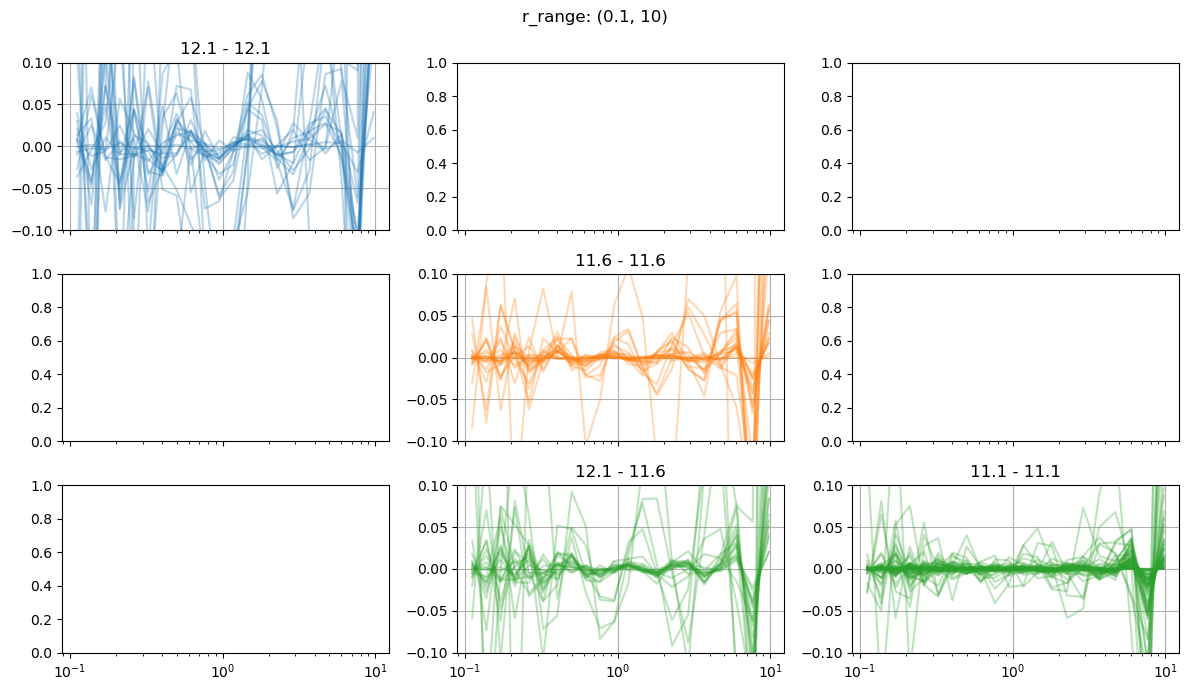

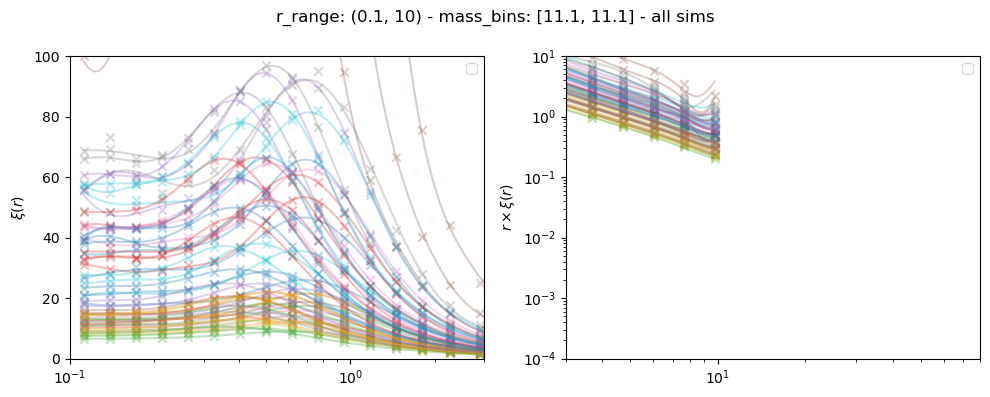

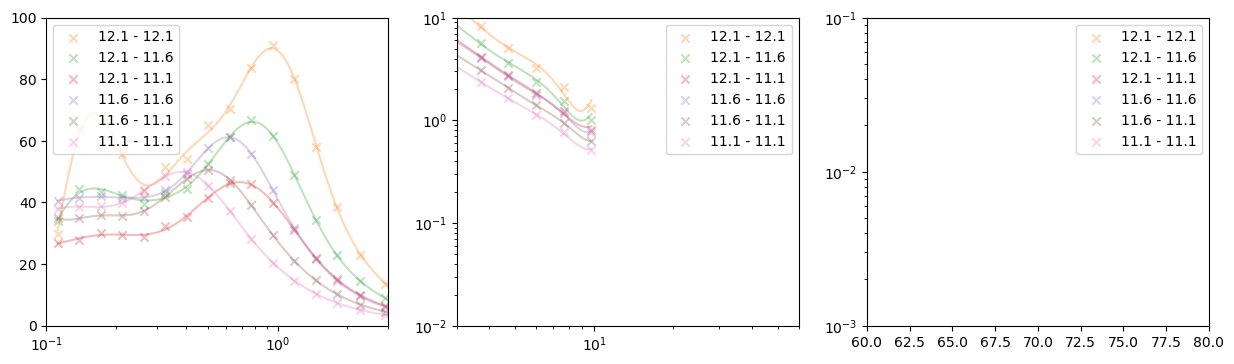

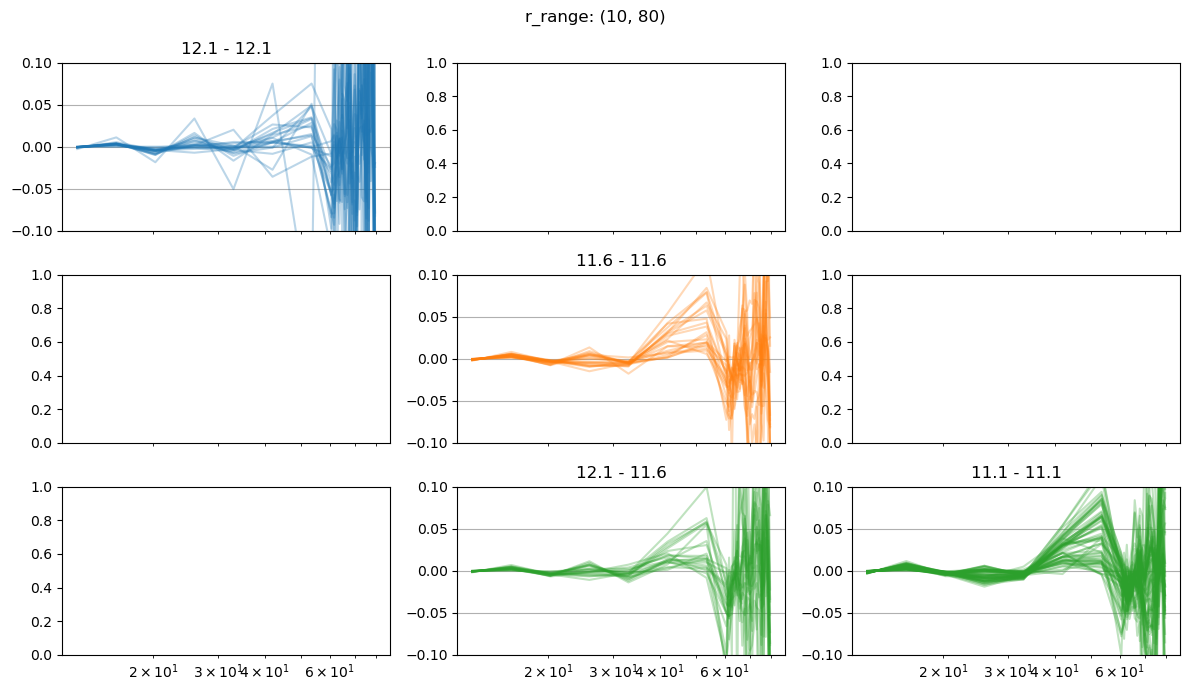

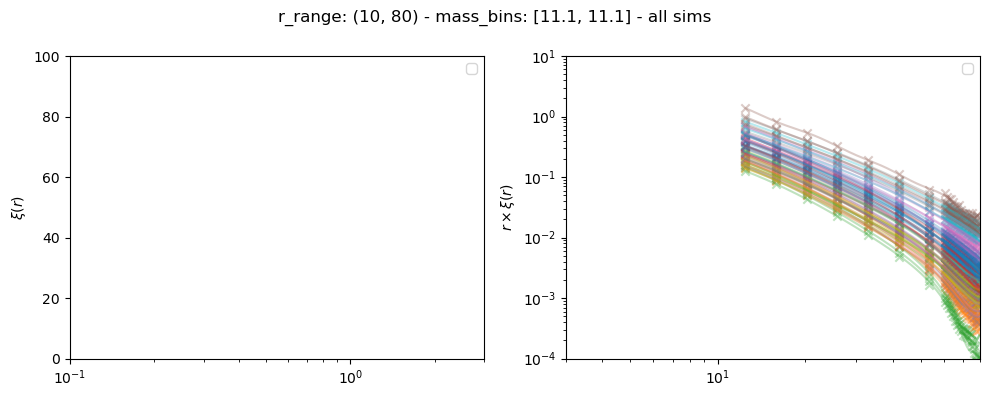

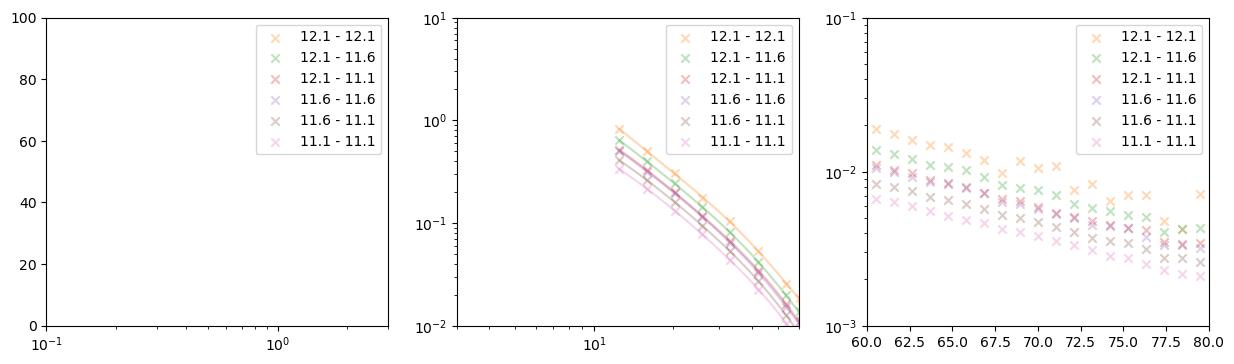

In [15]:
dim_reduc_gp(r_range=(0.1, 10))
dim_reduc_gp(r_range=(10, 80))
#dim_reduc_gp(r_range=(0.1, 30))


20 Negative correlation in [12.1, 12.1] of  3 removed
16 Negative correlation in [12.1, 12.1] of  15 removed
20 Negative correlation in [12.1, 12.1] of  17 removed
20 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/765046841.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


19 Negative correlation in [12.1, 11.6] of  15 removed
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │         value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 476.764       │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   4.23726e-07 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │   0.01   

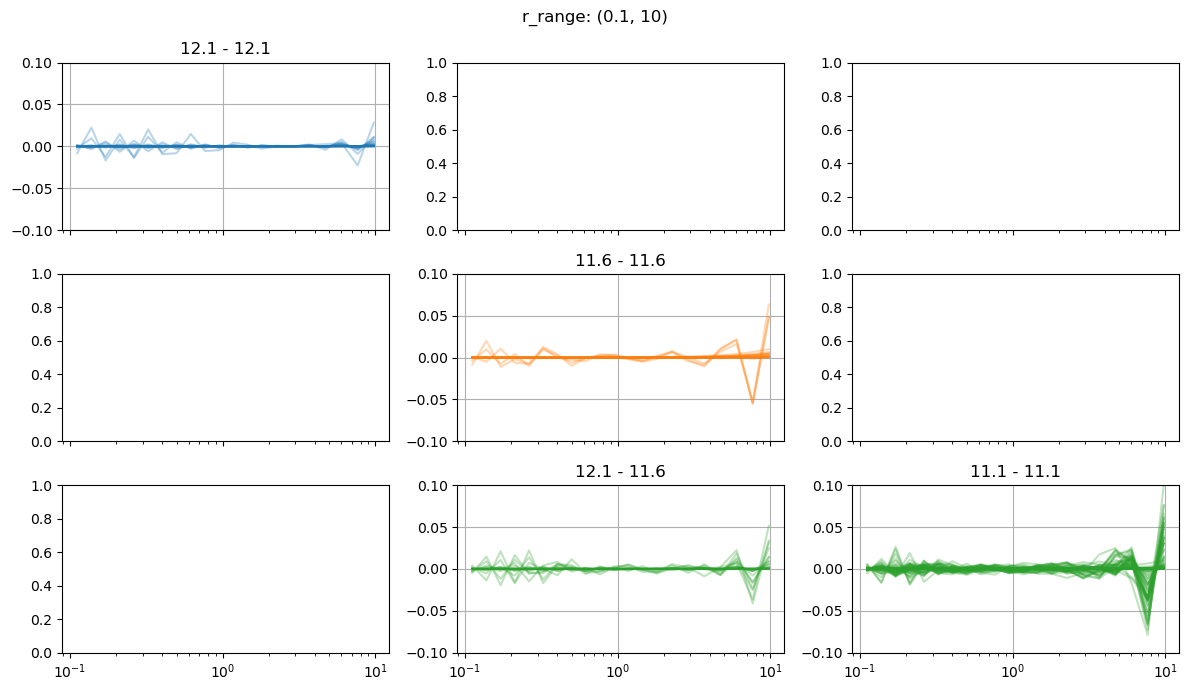

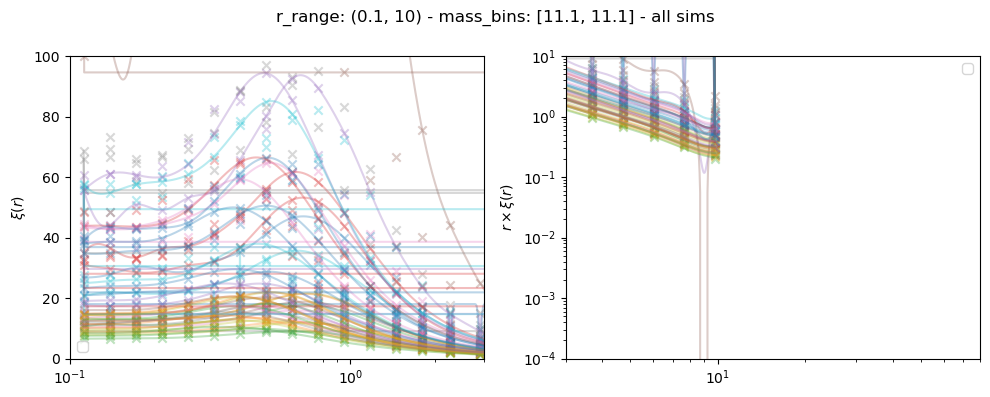

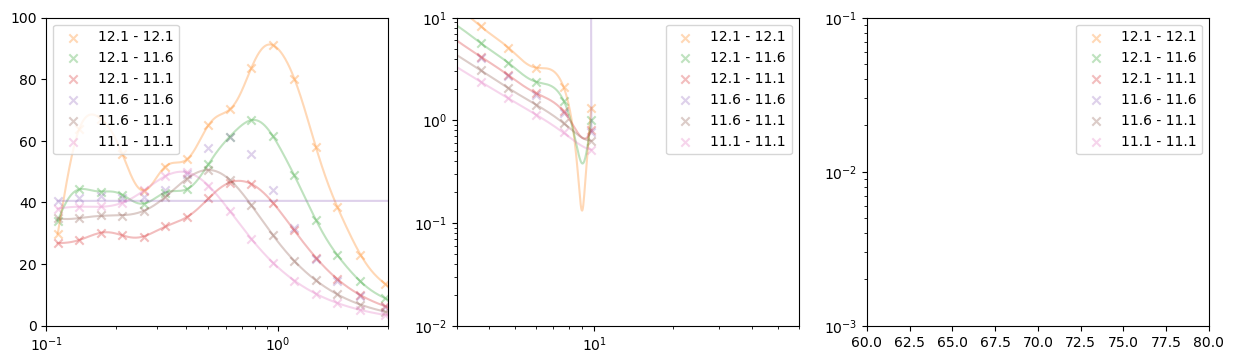

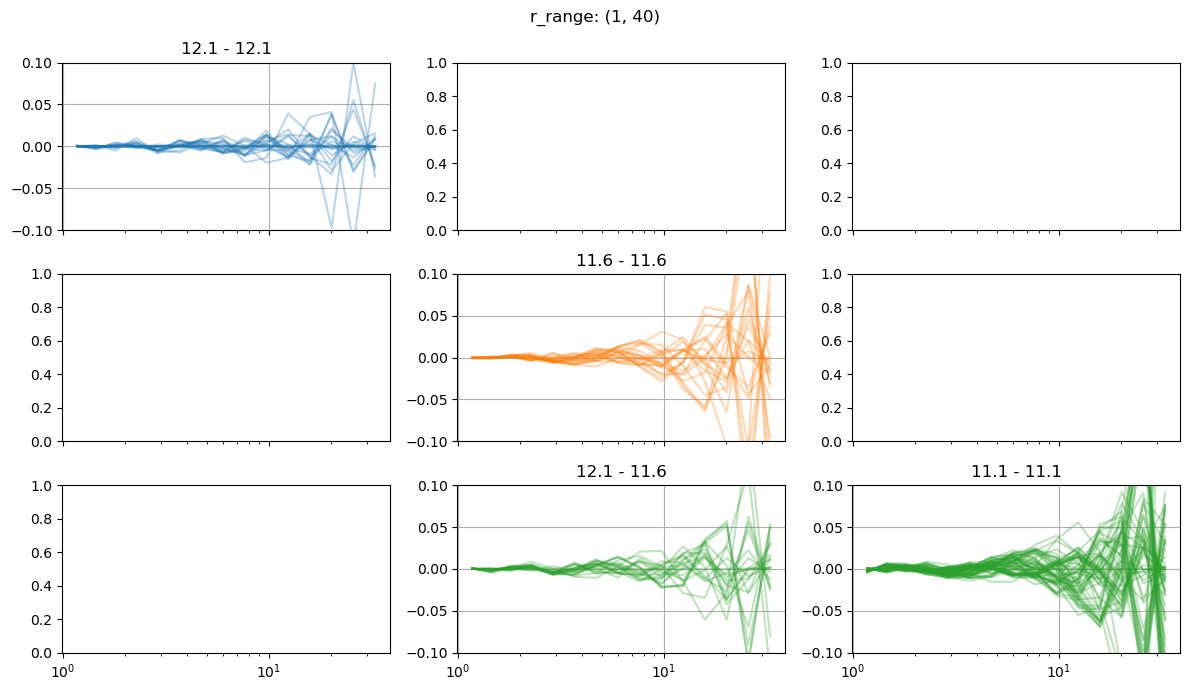

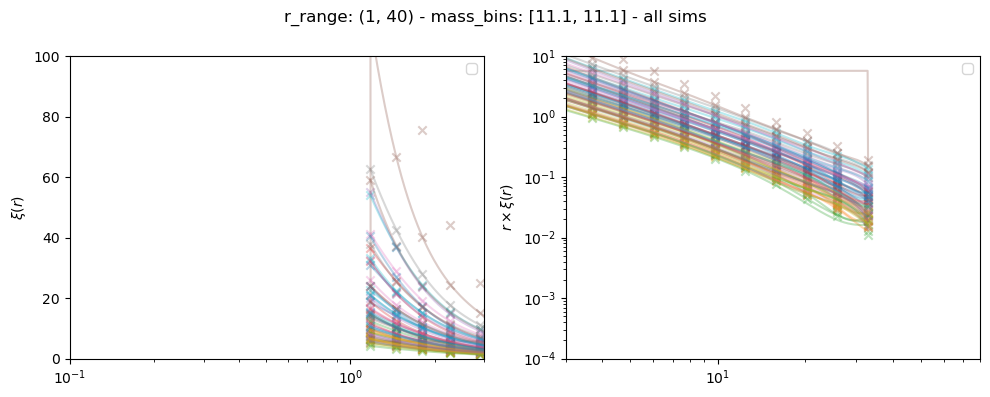

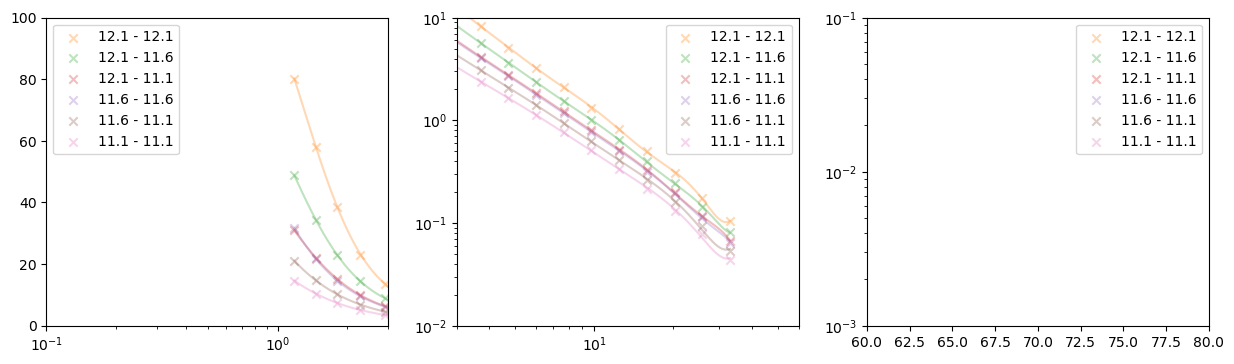

In [13]:
dim_reduc_gp(r_range=(0.1, 10), lik_var=0.01)
dim_reduc_gp(r_range=(1, 40), lik_var=0.001)
#dim_reduc_gp(r_range=(0.1, 30))


The comaprison above shows fixing the likliehood variance to 0.01 does a bad job where the fucntion itself is small (large scales). So the case with a learned the varaicne does a better job. 

Two solutions:

1. Have 2 different varaince for small and large scales
2. Use `GPR.kernels.CahnegPoints()` to train 2 different GPs for the small and large scales, so the relative variance between these two scales doesn't matter.

25 Negative correlation in [12.1, 12.1] of  3 removed
21 Negative correlation in [12.1, 12.1] of  15 removed
25 Negative correlation in [12.1, 12.1] of  17 removed
25 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/765046841.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


24 Negative correlation in [12.1, 11.6] of  15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 656.91419            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 11.51124             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────

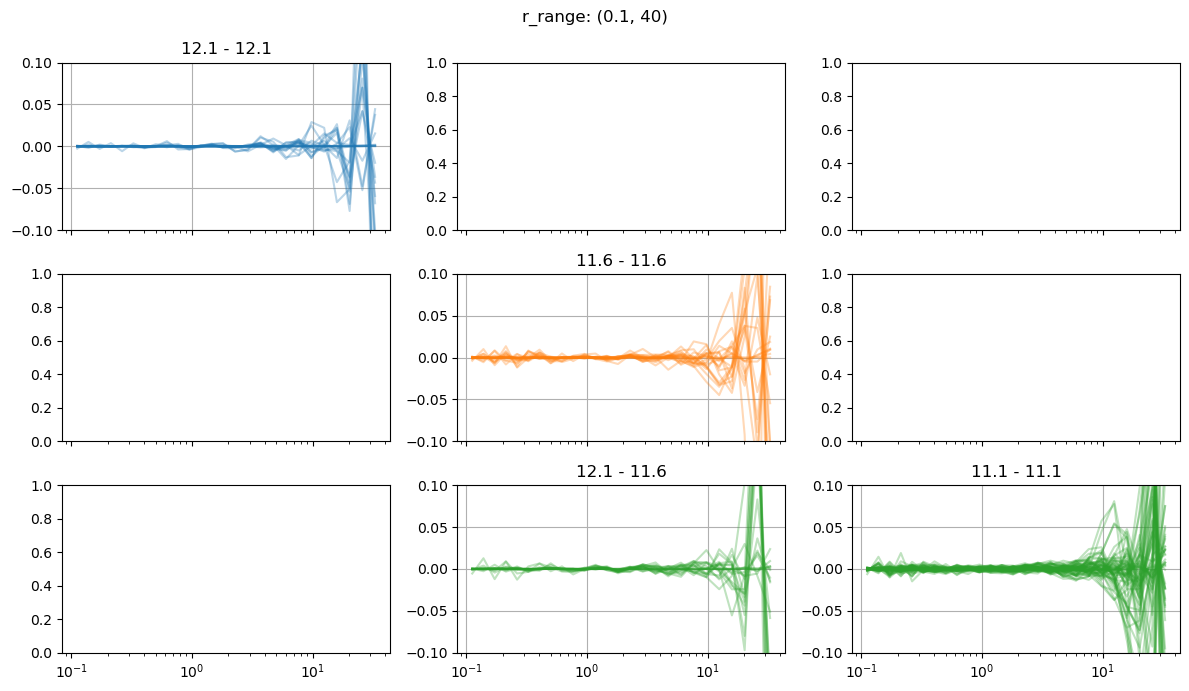

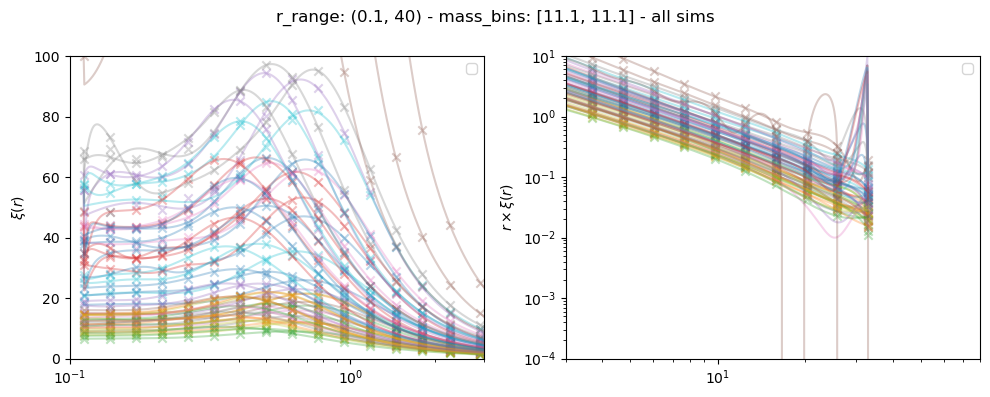

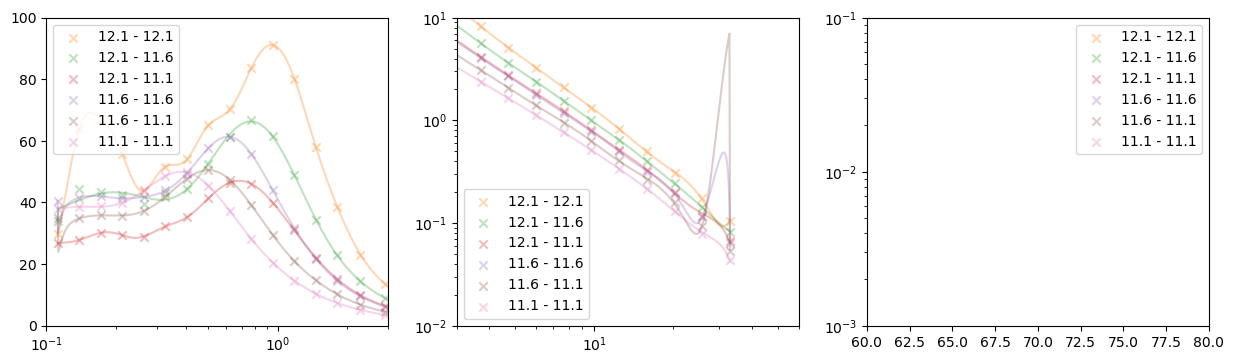

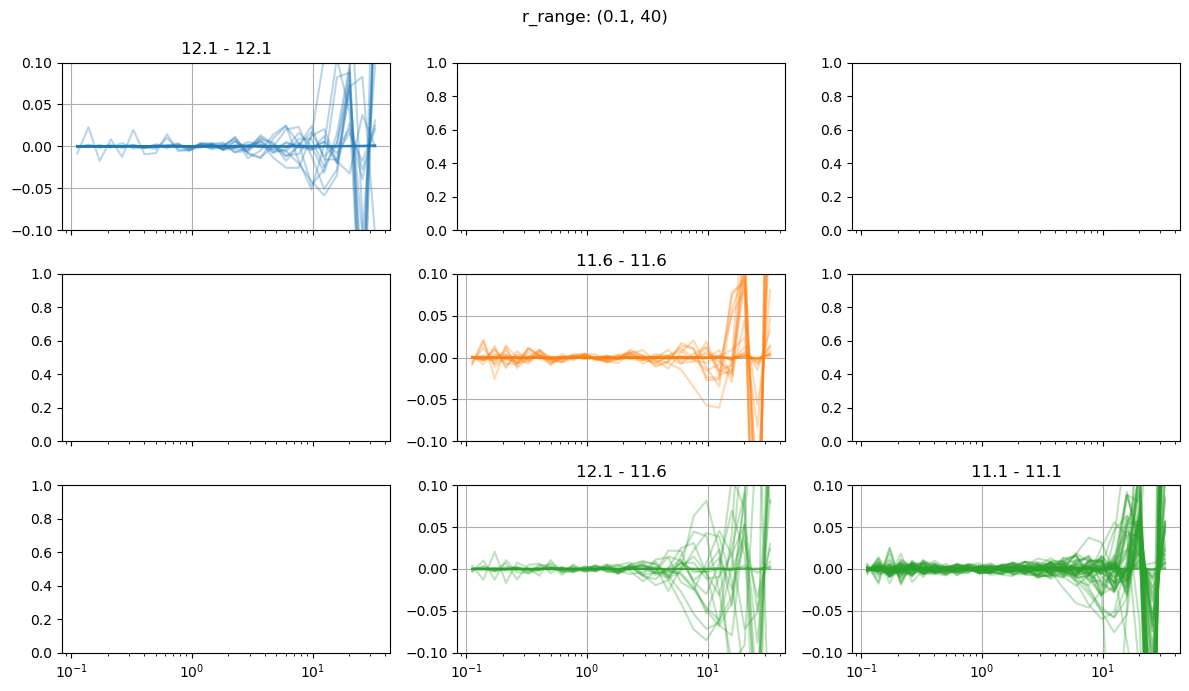

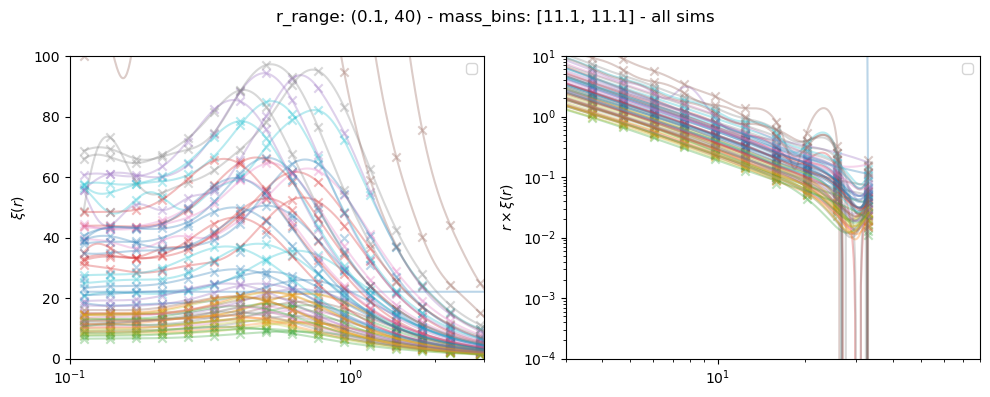

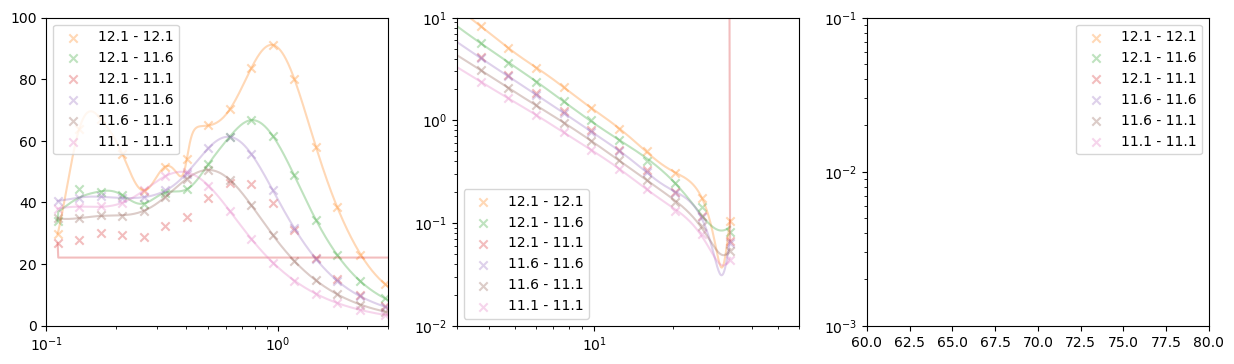

In [12]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 40), kernels=kernel, lik_var=0.01)

kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1,10], 'train_loc':True}
dim_reduc_gp(r_range=(0.1, 40), kernels=kernel, lik_var=0.01)

These plos show if we let GPR learn the change-points, it gets confused for some mass-bins.

What likliehood variance?

2025-03-02 00:29:13.271688: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2922.6637             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.06394488606935747   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[1].variance  

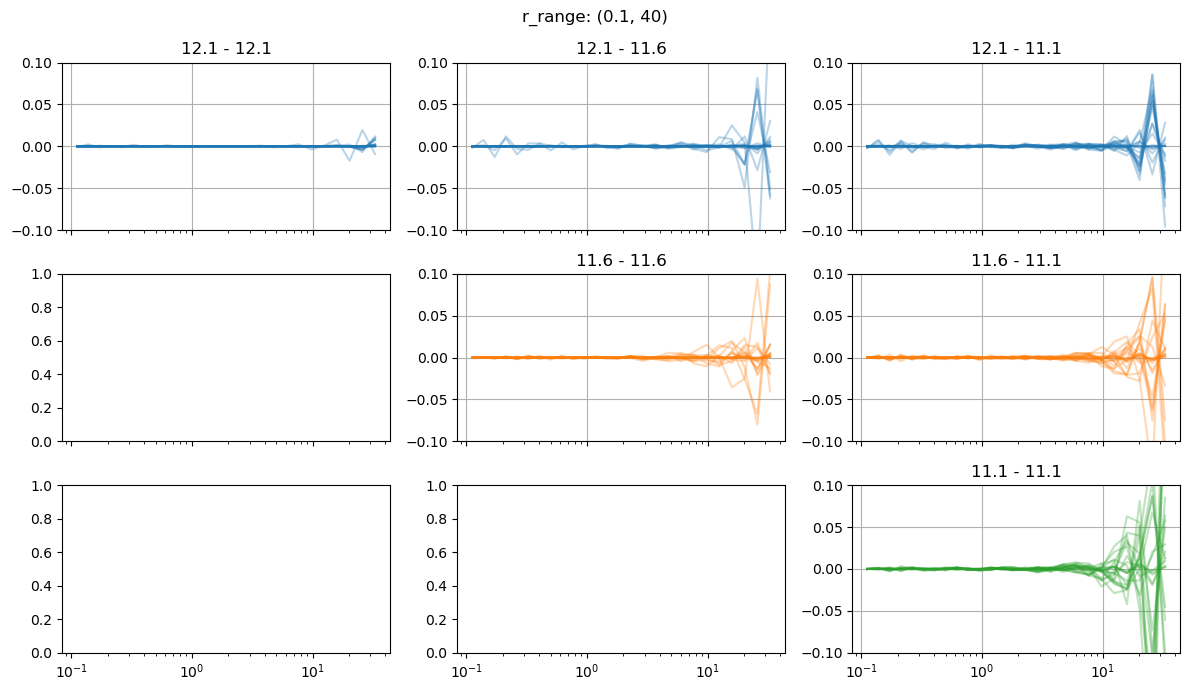

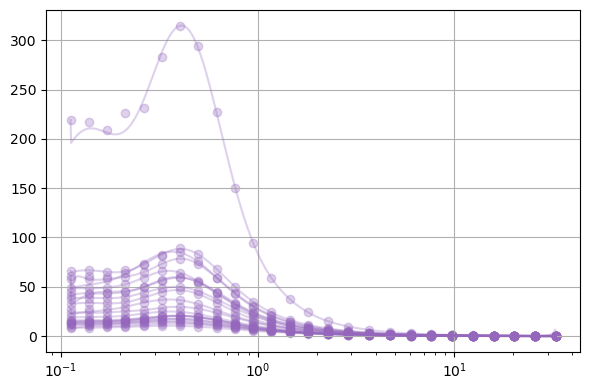

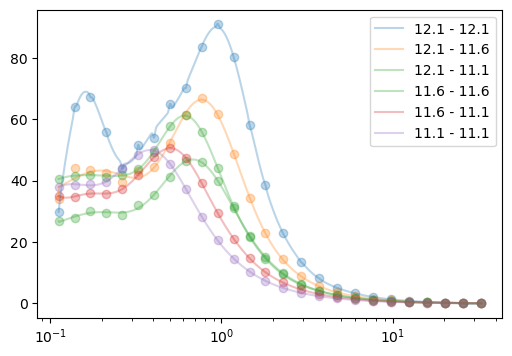

In [3]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 40), kernels=kernel, lik_var=0.001)

smaller varaince does better for larger scales.

let the variance be leanred then:

25 Negative correlation in [12.1, 12.1] of  3 removed
21 Negative correlation in [12.1, 12.1] of  15 removed
25 Negative correlation in [12.1, 12.1] of  17 removed
25 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/765046841.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


24 Negative correlation in [12.1, 11.6] of  15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1297.35694              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.245970797899635       │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼──

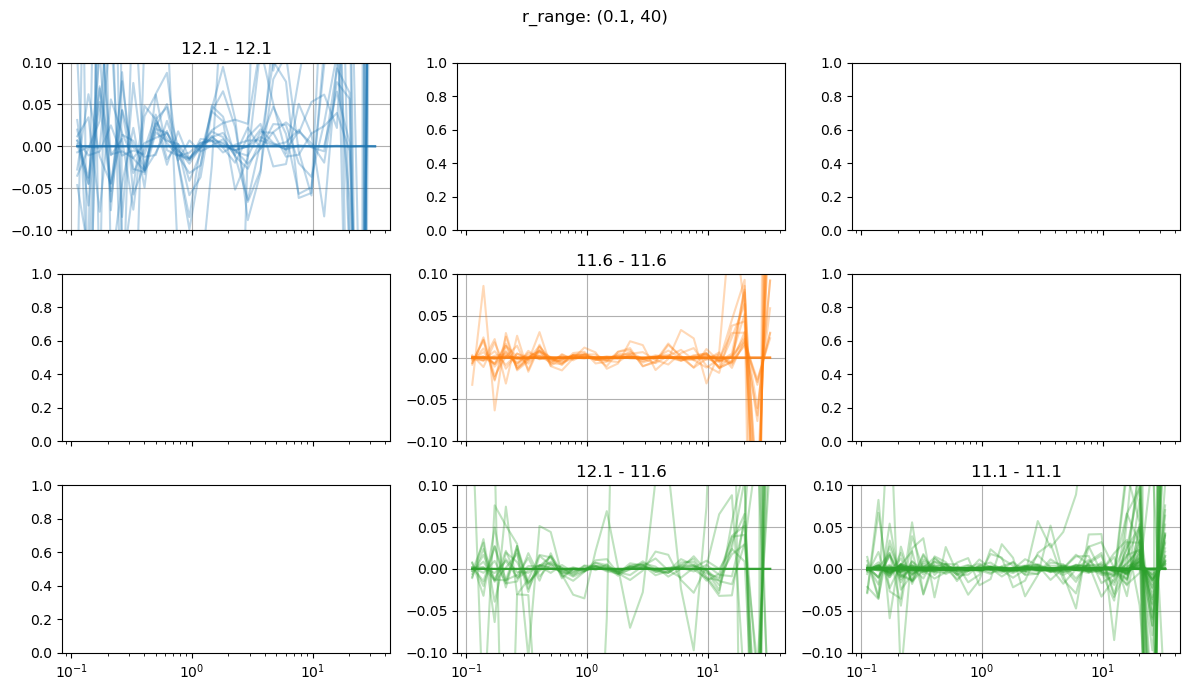

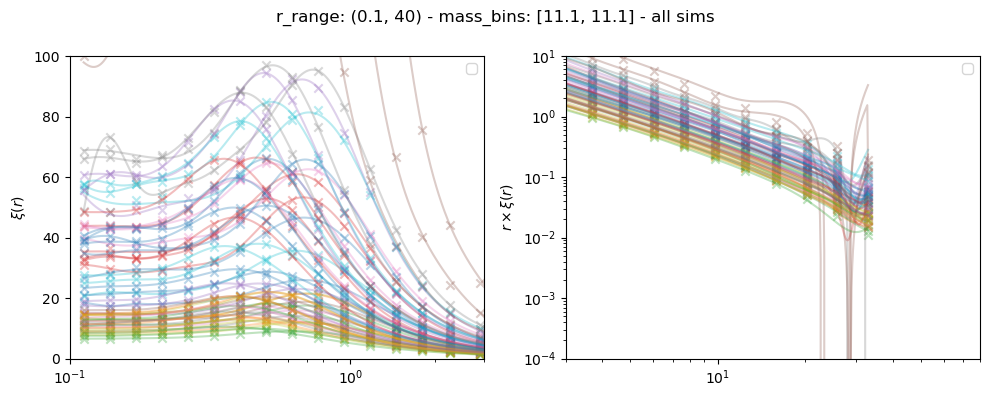

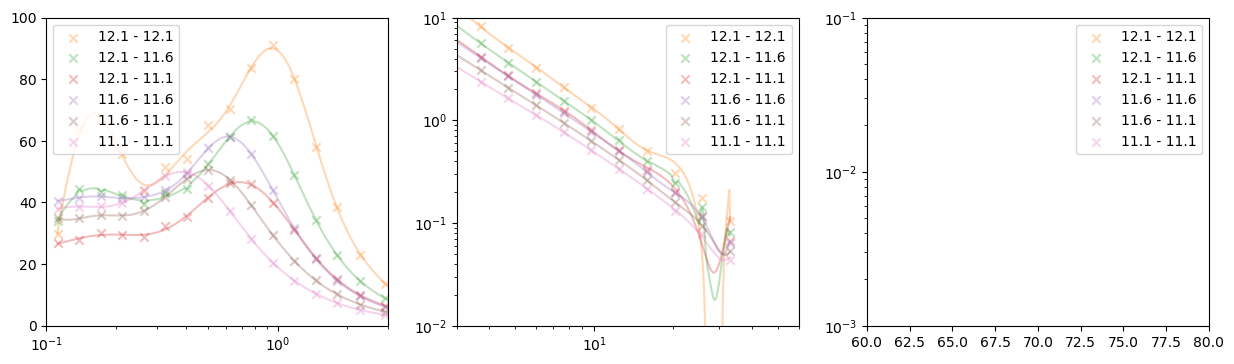

In [11]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 40), kernels=kernel, lik_var=None)

The fits gets bad for some sims if we let likeliehood varaince to be a hyper param.

Full scale:

27 Negative correlation in [12.1, 12.1] of  3 removed
23 Negative correlation in [12.1, 12.1] of  15 removed
27 Negative correlation in [12.1, 12.1] of  17 removed
27 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/765046841.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


26 Negative correlation in [12.1, 11.6] of  15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.72076                │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0118593800450576e-07 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────────

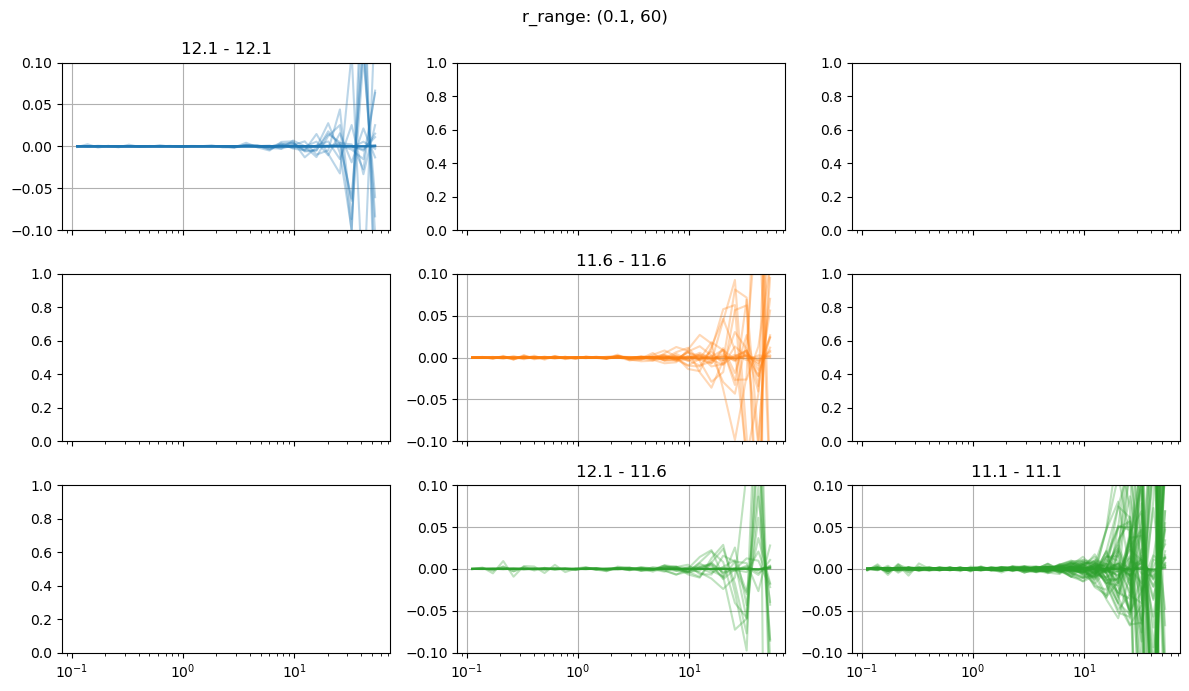

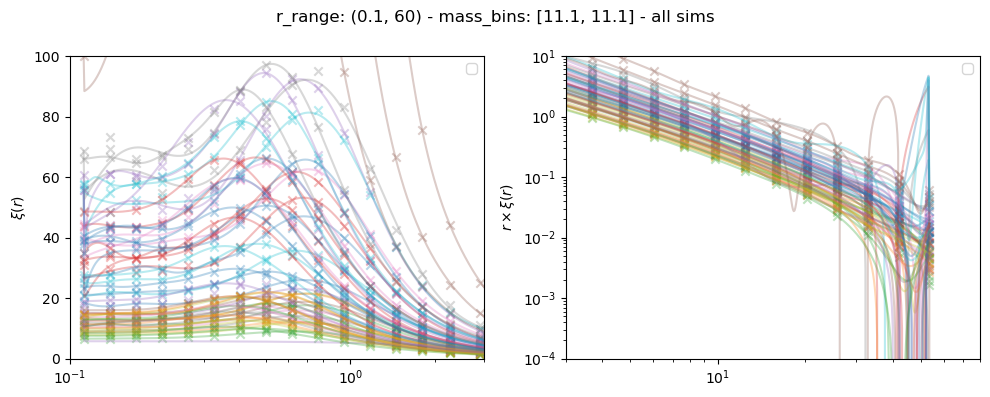

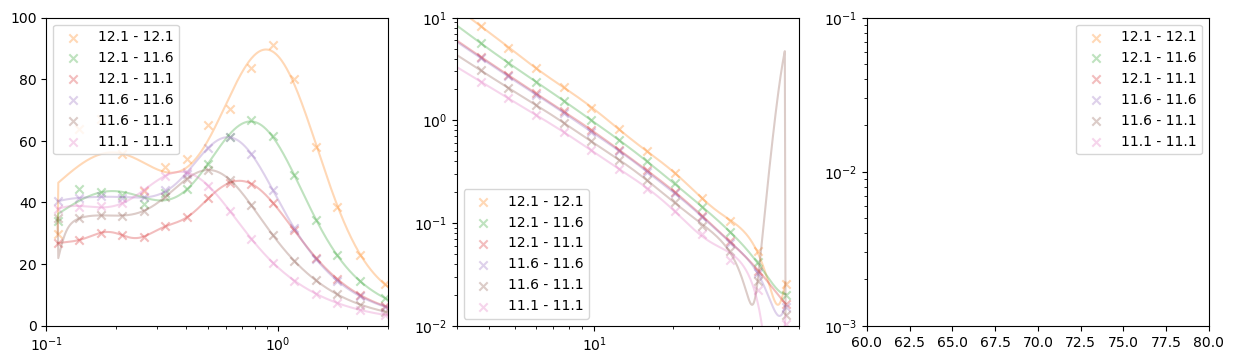

In [10]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 60), kernels=kernel, lik_var=0.001)


To even larger scales:

46 Negative correlation in [12.1, 12.1] of  3 removed
41 Negative correlation in [12.1, 12.1] of  15 removed
46 Negative correlation in [12.1, 12.1] of  17 removed
46 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/4078154054.py:154: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


45 Negative correlation in [12.1, 11.6] of  15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 440.14478               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.1477280713745555e-118 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼──

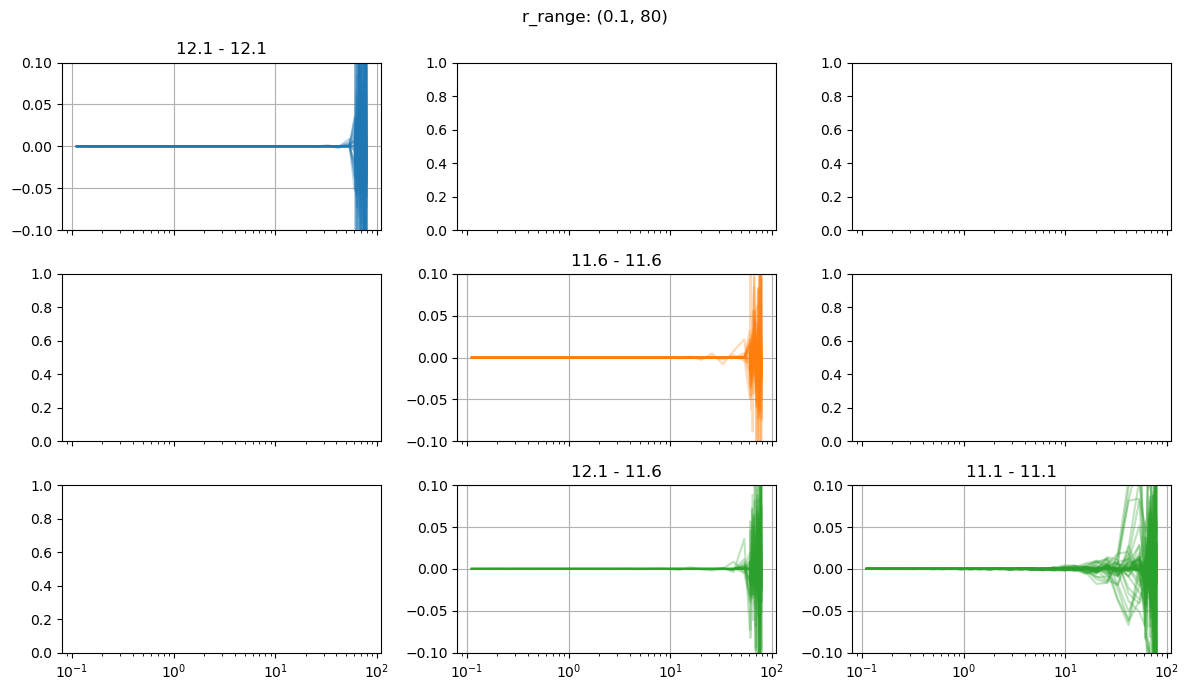

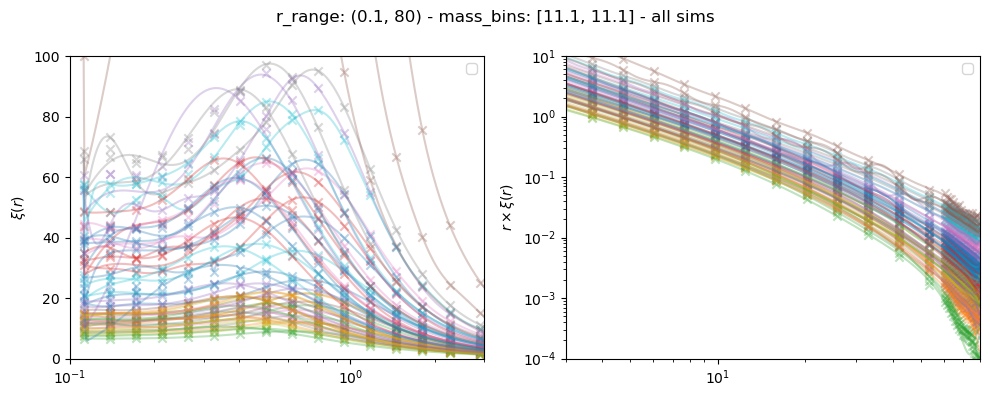

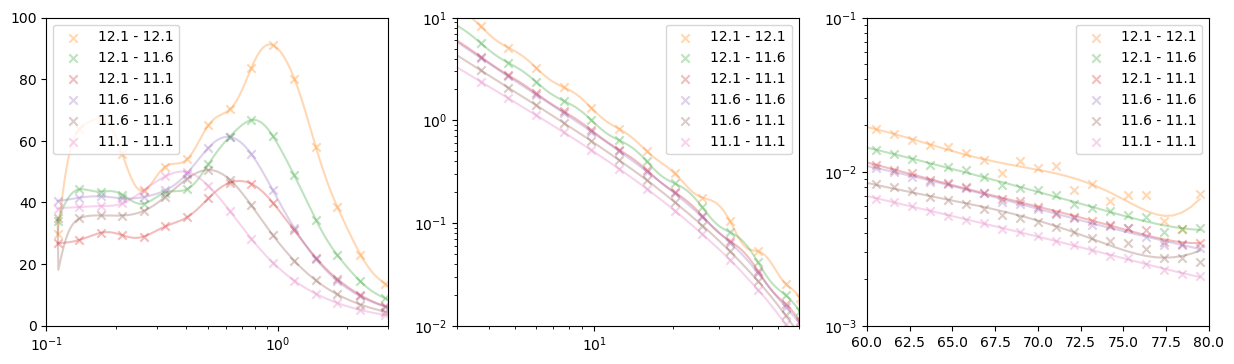

In [25]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel, lik_var=1e-5)


- [ ] Maybe let the GPR find different steepness for the transitions, maybe add another changepoint at r ~ 60 ? Our sampling is linear after 60.

46 Negative correlation in [12.1, 12.1] of  3 removed
41 Negative correlation in [12.1, 12.1] of  15 removed
46 Negative correlation in [12.1, 12.1] of  17 removed
46 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/4078154054.py:154: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


45 Negative correlation in [12.1, 11.6] of  15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                     │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 245.23379                 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.0890765301702833e-80    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

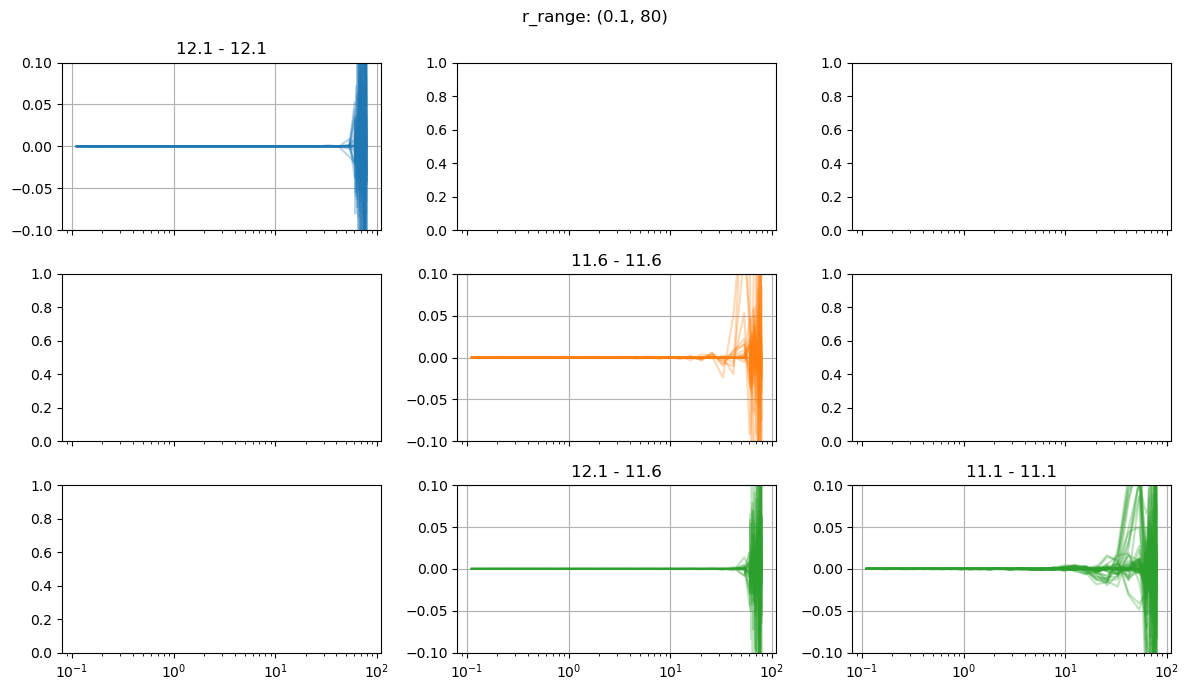

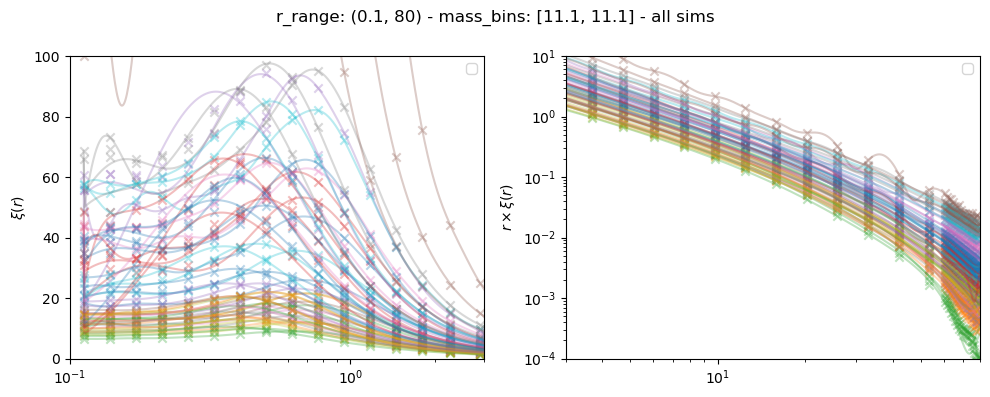

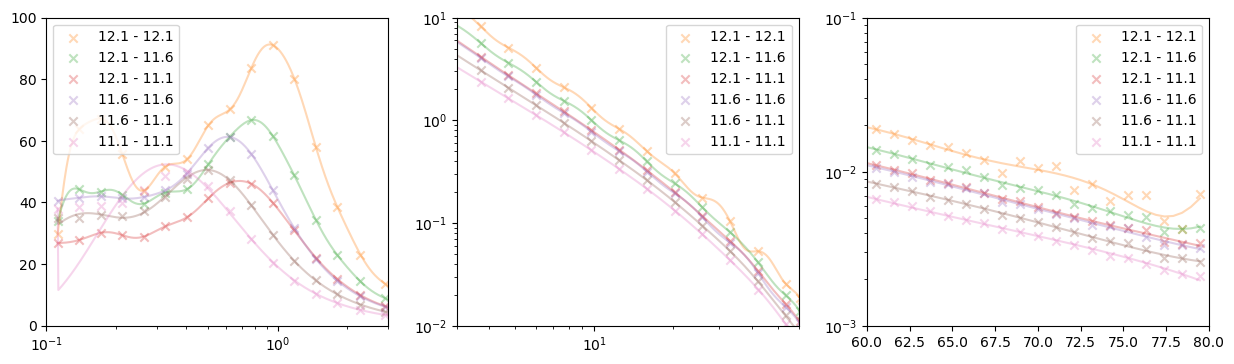

In [27]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10, 60], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel, lik_var=1e-5)


Adding naother changing point at 60 just makes the fit worse.

Train all chunks in log-scale for corr:

46 Negative correlation in [12.1, 12.1] of  3 removed
41 Negative correlation in [12.1, 12.1] of  15 removed
46 Negative correlation in [12.1, 12.1] of  17 removed
46 Negative correlation in [12.1, 12.1] of  20 removed


/tmp/ipykernel_2120328/4078154054.py:154: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


45 Negative correlation in [12.1, 11.6] of  15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.4592812240900148e-06 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 14.62197               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────────

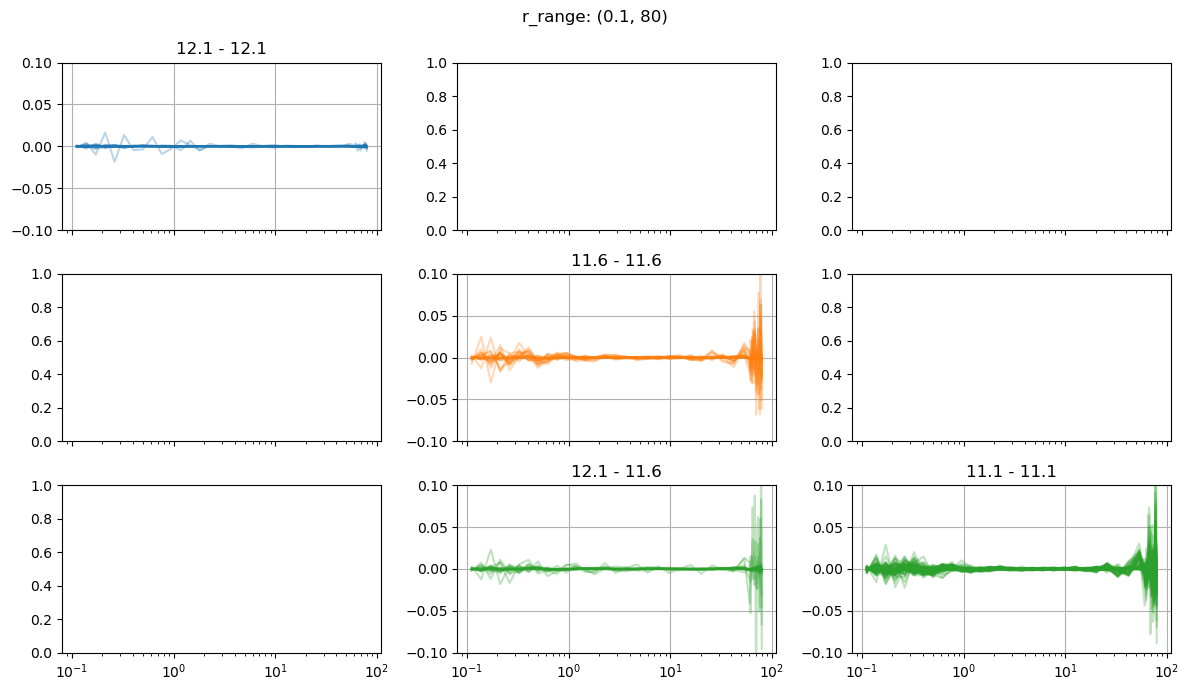

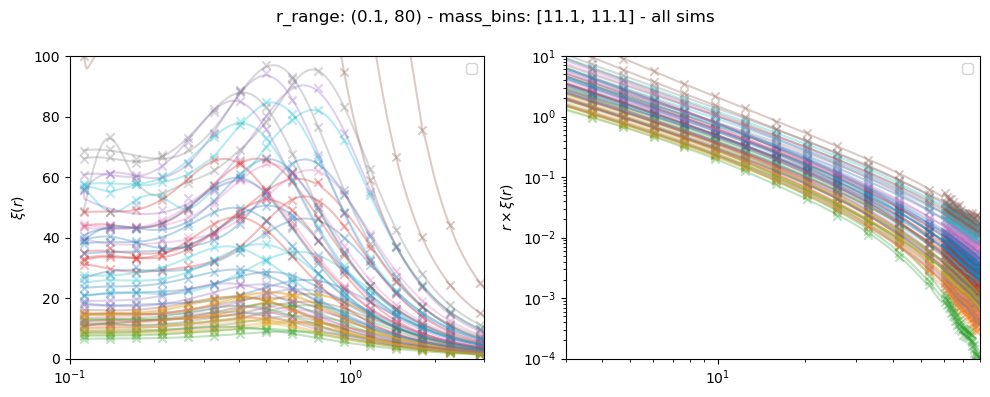

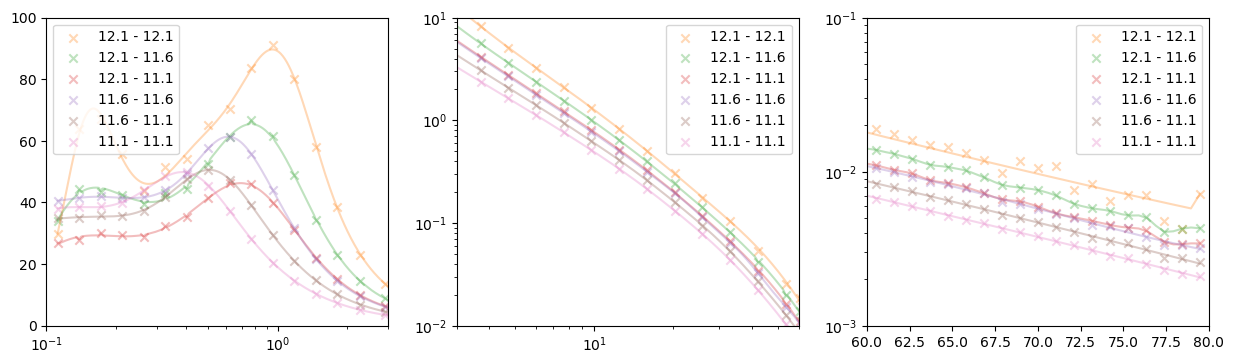

In [29]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel, lik_var=1e-5, log_y=True)


The last model is the winner! 

## Dim reduc on L2:

4 Negative correlation in [12.1, 12.1] of  0 removed


2025-03-03 22:52:16.797362: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


7 Negative correlation in [12.1, 12.1] of  1 removed
6 Negative correlation in [12.1, 12.1] of  2 removed
6 Negative correlation in [12.1, 12.1] of  3 removed
9 Negative correlation in [12.1, 12.1] of  4 removed
5 Negative correlation in [12.1, 12.1] of  6 removed
16 Negative correlation in [12.1, 12.1] of  7 removed
6 Negative correlation in [12.1, 12.1] of  8 removed
7 Negative correlation in [12.1, 12.1] of  9 removed
6 Negative correlation in [12.1, 12.1] of  10 removed
9 Negative correlation in [12.1, 12.1] of  11 removed
14 Negative correlation in [12.1, 12.1] of  12 removed
47 Negative correlation in [12.1, 12.1] of  13 removed
8 Negative correlation in [12.1, 12.1] of  14 removed
26 Negative correlation in [12.1, 12.1] of  15 removed
6 Negative correlation in [12.1, 12.1] of  16 removed
4 Negative correlation in [12.1, 12.1] of  17 removed
8 Negative correlation in [12.1, 12.1] of  18 removed
9 Negative correlation in [12.1, 12.1] of  19 removed
15 Negative correlation in [12.1

/tmp/ipykernel_2123893/2500471727.py:174: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


1 Negative correlation in [12.1, 11.6] of  0 removed
6 Negative correlation in [12.1, 11.6] of  1 removed
2 Negative correlation in [12.1, 11.6] of  2 removed
4 Negative correlation in [12.1, 11.6] of  3 removed
8 Negative correlation in [12.1, 11.6] of  4 removed
8 Negative correlation in [12.1, 11.6] of  7 removed
3 Negative correlation in [12.1, 11.6] of  8 removed
1 Negative correlation in [12.1, 11.6] of  10 removed
3 Negative correlation in [12.1, 11.6] of  11 removed
5 Negative correlation in [12.1, 11.6] of  12 removed
28 Negative correlation in [12.1, 11.6] of  13 removed
2 Negative correlation in [12.1, 11.6] of  14 removed
16 Negative correlation in [12.1, 11.6] of  15 removed
1 Negative correlation in [12.1, 11.6] of  16 removed
1 Negative correlation in [12.1, 11.6] of  17 removed
7 Negative correlation in [12.1, 11.6] of  19 removed
15 Negative correlation in [12.1, 11.6] of  20 removed
5 Negative correlation in [12.1, 11.6] of  21 removed
4 Negative correlation in [12.1,

/tmp/ipykernel_2123893/2500471727.py:201: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_full.tight_layout()


bad_sims: [[12.1, 12.1, 13], [12.1, 12.1, 63], [12.1, 12.1, 66], [12.1, 12.1, 122], [12.1, 12.1, 156], [12.1, 12.1, 169], [12.1, 12.1, 244], [12.1, 12.1, 395], [12.1, 12.1, 417], [12.1, 12.1, 436], [12.1, 12.1, 452], [12.1, 12.1, 501], [12.1, 12.1, 545], [12.1, 12.1, 549], [11.6, 11.6, 172], [11.6, 11.6, 444], [11.6, 11.6, 474]]


/home/qezlou/.local/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


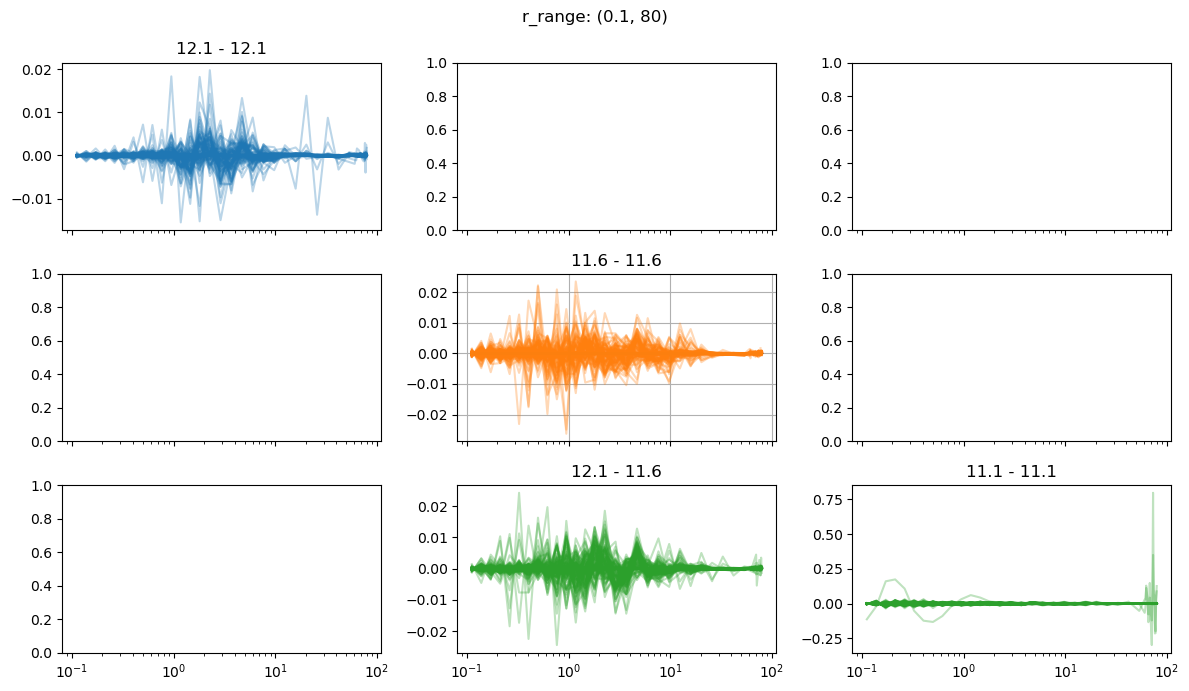

/home/qezlou/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


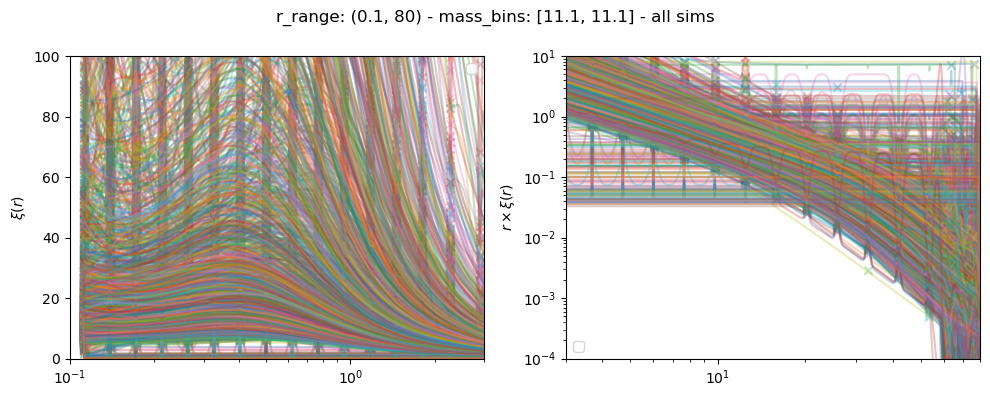

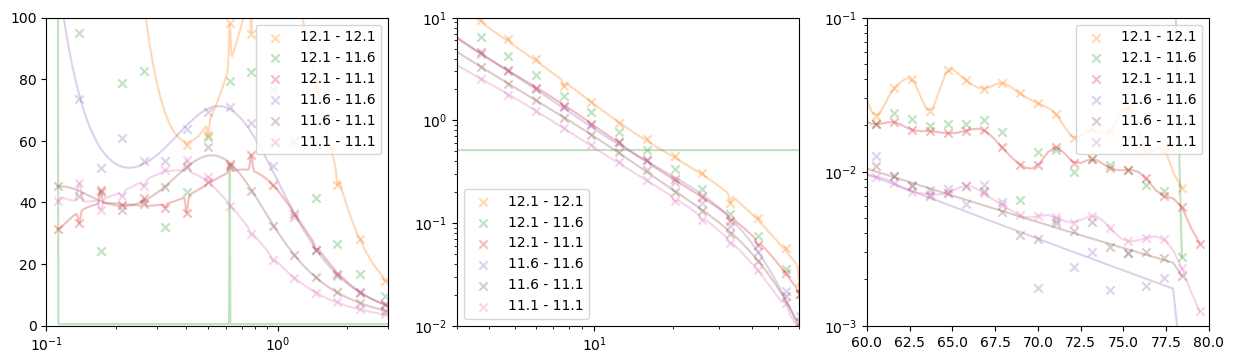

In [2]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(fid='L2', r_range=(0.1, 80), kernels=kernel, lik_var=1e-5, log_y=True)
